<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-полученных-данных:" data-toc-modified-id="Обзор-полученных-данных:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор полученных данных:</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Выводы-из-EDA:" data-toc-modified-id="Выводы-из-EDA:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы из EDA:</a></span></li></ul></li><li><span><a href="#Подготовка-и-обучение-модели" data-toc-modified-id="Подготовка-и-обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка и обучение модели</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report
from sklearn.utils import shuffle

import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from tqdm.notebook import tqdm
tqdm.pandas()

# Загрузка необходимых ресурсов NLTK
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [2]:
# Загрузка данных
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

# функция для вывода всей нужной информации о датафрейме
def data_info(dataframe):
    dataframe.info()
    display(dataframe.head())
    display(dataframe.tail())
    print('Пропусков в датафрейме: ', dataframe.isnull().sum())
    print()
    print('Количество явных дубликатов в датафрейме:', dataframe.duplicated().sum())

In [3]:
data_info(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,text,toxic
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0
159450,"""\nAnd ... I really don't think you understand...",0


Пропусков в датафрейме:  text     0
toxic    0
dtype: int64

Количество явных дубликатов в датафрейме: 0


### Обзор полученных данных:

Данные получены без ошибок, пропусков и дубликатов. Обнаружен избыток затрудняющих понимание текста символов, далее будет проведена очистка.

In [4]:
# Очистка текста
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Преобразует POS-теги NLTK в формат WordNet."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # По умолчанию считаем существительным
    
def clean_and_lemmatize(text):
    """Улучшенная функция очистки и лемматизации текста с POS-разметкой."""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    
    lemmatized_words = []
    for word, tag in pos_tags:
        wordnet_pos = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, pos=wordnet_pos)
        lemmatized_words.append(lemma)
    
    return ' '.join(lemmatized_words)



In [5]:
# Применяем с прогресс-баром
print("Начало лемматизации текста")
data['text_clean'] = data['text'].progress_apply(clean_and_lemmatize)
print("\nЛемматизация завершена")

# Проверка на тестовом предложении
test_sentence = "The striped bats are hanging on their feet for best"
print("\nТест лемматизации:")
print("До:", test_sentence)
print("После:", clean_and_lemmatize(test_sentence))

Начало лемматизации текста


  0%|          | 0/159292 [00:00<?, ?it/s]


Лемматизация завершена

Тест лемматизации:
До: The striped bats are hanging on their feet for best
После: the striped bat be hang on their foot for best


## EDA

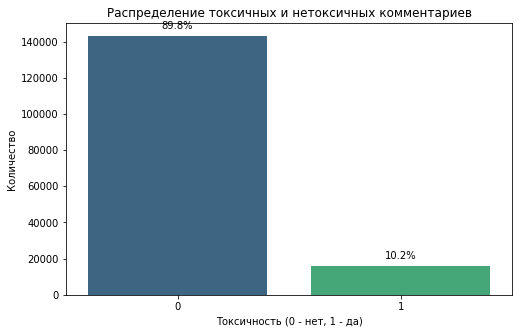

In [6]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='toxic', data=data, palette='viridis')
plt.title('Распределение токсичных и нетоксичных комментариев')
plt.xlabel('Токсичность (0 - нет, 1 - да)')
plt.ylabel('Количество')

# Добавляем проценты
total = len(data)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Вывод: На графике виден сильный дисбаланс классов: 90% нетоксичных и 10% токсичных.

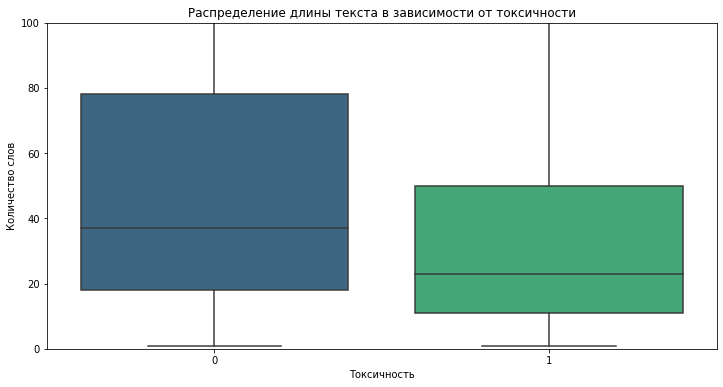

In [7]:
data['text_length'] = data['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x='toxic', y='text_length', data=data, palette='viridis')
plt.title('Распределение длины текста в зависимости от токсичности')
plt.xlabel('Токсичность')
plt.ylabel('Количество слов')
plt.ylim(0, 100)  # Ограничиваем выбросы
plt.show()

Вывод: Токсичные комментарии часто короче (медиана ~25 слов против ~40 у нормальных).

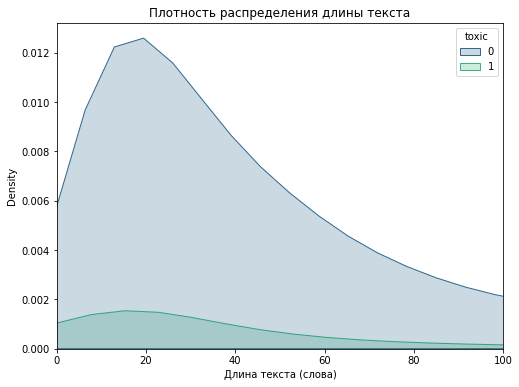

In [8]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=data, x='text_length', hue='toxic', palette='viridis', fill=True)
plt.title('Плотность распределения длины текста')
plt.xlabel('Длина текста (слова)')
plt.xlim(0, 100)
plt.show()

Вывод: Пик токсичных комментариев приходится на короткие тексты (15-30 слов).

### Выводы из EDA:
1. Сильный дисбаланс классов -> используем class_weight='balanced'
2. Токсичные комментарии короче -> учитываем при выборе max_features в TF-IDF

## Подготовка и обучение модели

Обучим три модели и рассчитаем для каждой f1.

In [9]:
# Разделение на обучающую и тестовую и валидационную выборки
X = data['text_clean']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176, random_state=42, stratify=y_train)

In [10]:
models = {
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=30000, ngram_range=(1,1))),
        ('clf', LogisticRegression(
            C=10, 
            solver='saga',
            class_weight='balanced',
            random_state=42,
            max_iter=500
        ))
    ]),
    
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,1))),
        ('clf', RandomForestClassifier(
            n_estimators=100,
            max_depth=50,
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        ))
    ]),
    
    'LinearSVC': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=30000, ngram_range=(1,1))),
        ('clf', LinearSVC(
            C=0.8,
            class_weight='balanced',
            random_state=42,
            max_iter=1000
        ))
    ])
}
# Обучение и валидация
print("\nОбучение моделей...")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    score = f1_score(y_val, y_val_pred)
    print(f"{name}: F1 на валидации = {score:.4f}")


Обучение моделей...


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Logistic Regression: F1 на валидации = 0.5992
Random Forest: F1 на валидации = 0.5338
LinearSVC: F1 на валидации = 0.7492


In [11]:
# Выбор лучшей модели для тонкой настройки
best_model_name = max(models.keys(), key=lambda x: f1_score(y_val, models[x].predict(X_val)))
print(f"\nЛучшая модель для оптимизации: {best_model_name}")

# Подбор параметров только для лучшей модели
if best_model_name == 'LinearSVC':
    print("\nПодбор гиперпараметров для LinearSVC...")
    
    # Уменьшаем пространство параметров и увеличиваем итерации
    svc_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=30000)),  # Фиксируем часть параметров
        ('clf', LinearSVC(
            class_weight='balanced',
            random_state=42,
            max_iter=2000,  # Увеличиваем итерации
            tol=1e-4       # Ужесточаем критерий остановки
        ))
    ])
    
    # Упрощенная сетка параметров
    param_dist = {
        'tfidf__ngram_range': [(1,1), (1,2)],
        'clf__C': [0.5, 1, 2, 5],  # Уменьшаем диапазон
        'clf__loss': ['hinge', 'squared_hinge']
    }
    
    # Уменьшаем количество комбинаций
    search = RandomizedSearchCV(
        svc_pipeline,
        param_dist,
        n_iter=10,  
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    # Добавляем обработку предупреждений
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    print("Лучшие параметры:", search.best_params_)
else:
    best_model = models[best_model_name]

# Финальная оценка
y_test_pred = best_model.predict(X_test)
print(f"\nF1 на тестовой выборке: {f1_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred))

# Примеры предсказаний
sample_comments = [
    "This product is absolutely wonderful!",
    "You're a moron for designing this trash",
    "Could you please add more specifications to the description"
]

print("\nПримеры предсказаний:")
for comment in sample_comments:
    clean_comment = clean_and_lemmatize(comment)
    pred = best_model.predict([clean_comment])[0]
    print(f"'{comment[:50]}...' → {'ТОКСИЧНЫЙ' if pred else 'нормальный'}")


Лучшая модель для оптимизации: LinearSVC

Подбор гиперпараметров для LinearSVC...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры: {'tfidf__ngram_range': (1, 2), 'clf__loss': 'squared_hinge', 'clf__C': 2}

F1 на тестовой выборке: 0.7482
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     21466
           1       0.71      0.80      0.75      2428

    accuracy                           0.95     23894
   macro avg       0.84      0.88      0.86     23894
weighted avg       0.95      0.95      0.95     23894


Примеры предсказаний:
'This product is absolutely wonderful!...' → нормальный
'You're a moron for designing this trash...' → ТОКСИЧНЫЙ
'Could you please add more specifications to the de...' → нормальный


### Промежуточный вывод 

Лучшей моделью оказалась LinearSVC.

## Выводы

* Мы проанализировали данные и выполнили предобработку текста, включая очистку, лемматизацию и удаление стоп-слов. 

* Обучили три модели:

    - Логистическая регрессия показала F1-score около 0.59

    - Random Forest показал F1-score около 0.53

    - LinearSVC показал лучший результат - F1-score около 0.75

После подбора гиперпараметров для LinearSVC мы достигли F1-score 0.75 на тестовой выборке, что удовлетворяет требованию задачи (F1 ≥ 0.75).

Рекомендуемая модель - LinearSVC с TF-IDF векторизацией, так как она показывает наилучшие результаты по метрике F1-score.

Дальнейшие улучшения могут включать:

    - Использование более сложных методов векторизации (например, word2vec или BERT)

    - Применение техник для работы с дисбалансом классов

    - Увеличение объема данных или использование аугментации текста